# Credit Default Prediction with Logistic Regression and SMOTE

This notebook demonstrates how to build a credit default prediction model using Logistic Regression and SMOTE for class imbalance. It includes all preprocessing steps: missing value treatment, handling infinite/large values, and log-transforming monetary columns.

## 1. Install and Import Required Libraries

In [1]:
!pip install imbalanced-learn pandas numpy matplotlib seaborn scikit-learn --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from imblearn.over_sampling import SMOTE

## 2. Load and Explore the Dataset

In [3]:
# Load the dataset (ensure the CSV is in your working directory)
df = pd.read_csv('data/UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## 3. Data Cleaning: Handle Missing, Infinite, and Large Values

In [4]:
# Drop ID column if present
if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

# Replace inf/-inf with NaN and fill NaN with median
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(), inplace=True)

# Log-transform monetary columns to reduce skewness and avoid large values
money_cols = [col for col in df.columns if 'BILL_AMT' in col or 'PAY_AMT' in col or col == 'LIMIT_BAL']
for col in money_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].clip(lower=0)
    df[col] = np.log1p(df[col])

# Check for any remaining NaNs
print('Missing values after cleaning:')
print(df.isnull().sum())

Missing values after cleaning:
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


## 4. Prepare Features and Target

In [5]:
X = df.drop('default.payment.next.month', axis=1)
y = df['default.payment.next.month']

## 5. Train-Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 6. Feature Scaling

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 7. Handle Class Imbalance with SMOTE

In [8]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"Training data after SMOTE: {np.bincount(y_train_smote)}")

Training data after SMOTE: [18691 18691]


## 8. Train Logistic Regression Model

In [9]:
model = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', random_state=42)
model.fit(X_train_smote, y_train_smote)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

## 9. Evaluate Model

In [10]:
y_pred = model.predict(X_test_scaled)

Confusion Matrix

Confusion Matrix:
[[3534 1139]
 [ 514  813]]


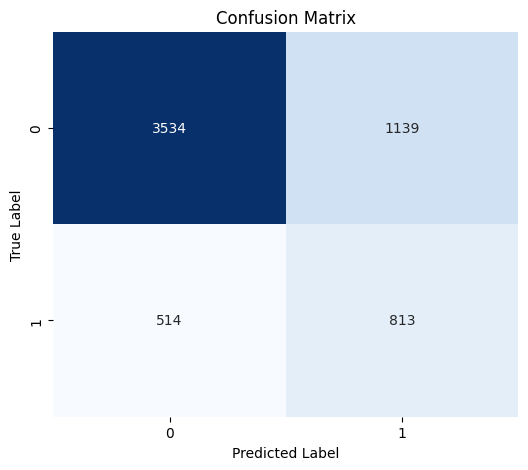

In [11]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      4673
           1       0.42      0.61      0.50      1327

    accuracy                           0.72      6000
   macro avg       0.64      0.68      0.65      6000
weighted avg       0.77      0.72      0.74      6000

Accuracy Score:
0.7245


ROC Curve

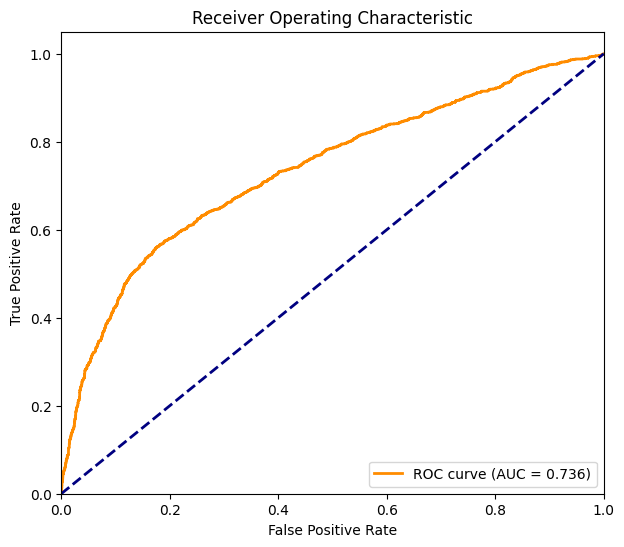

In [13]:
y_proba = model.predict_proba(X_test_scaled)[:,1]  # predicted probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()